# COMPGW02/M041: Web Economics Project

## Group 7: Zhilin Cai, Yuncan Zhang, Yao Fu
###  {zhilin.cai.16, yuncan.zhang.16, yao.fu.16}@ucl.ac.uk

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

/usr/local/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
df_train_original = pd.read_csv('train.csv')
df_validation_original = pd.read_csv('validation.csv')
df_test_original = pd.read_csv('test.csv')

# Preprocess

## Split os and browser

In [3]:
# split os and browser
def split_useragent_os(data):
    return data.split('_')[0]
def split_useragent_b(data):
    return data.split('_')[1]
def split_useragent(dataframe):
    dataframe['os'] = dataframe['useragent'].apply(split_useragent_os)
    dataframe['browser'] = dataframe['useragent'].apply(split_useragent_b)
    dataframe.drop(['useragent'], axis=1, inplace=True)

split_useragent(df_train_original)
split_useragent(df_validation_original)
split_useragent(df_test_original)

## Drop features

In [4]:
col_to_drop1 = ['city','slotid','slotprice','IP','domain','usertag','creative','logtype','bidid','userid','url','urlid','bidprice','payprice','keypage']
# col_to_drop2 = ['IP','domain','usertag','creative','logtype','bidid','userid','url','urlid','bidprice','payprice','keypage']
test_to_drop = ['city','slotid','slotprice','IP','domain','usertag','creative','logtype','bidid','userid','url','urlid','keypage']

In [5]:
df_train = df_train_original.drop(col_to_drop1, axis=1)
df_validation = df_validation_original.drop(col_to_drop1, axis=1)
df_test = df_test_original.drop(test_to_drop, axis=1)

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2697738 entries, 0 to 2697737
Data columns (total 12 columns):
click             int64
weekday           int64
hour              int64
region            int64
adexchange        object
slotwidth         int64
slotheight        int64
slotvisibility    object
slotformat        object
advertiser        int64
os                object
browser           object
dtypes: int64(7), object(5)
memory usage: 247.0+ MB


In [7]:
# pd.get_dummies(df_train['adexchange'],prefix='adexchange')

In [8]:
# print len(df_train.slotformat.unique())
# print len(df_test.slotformat.unique())

In [9]:
# df_train.slotvisibility.unique()

In [10]:
def onehot(onehot_df, column_name):
    dummies = pd.get_dummies(onehot_df[column_name],prefix=column_name)
    onehot_df = onehot_df.join(dummies)
    onehot_df = onehot_df.drop([column_name], axis=1)
    return onehot_df

In [11]:
column_to_onehot = ['weekday','hour','region','adexchange','slotformat','os','browser','slotwidth','slotheight','slotvisibility']
for col_name in column_to_onehot:
    df_train = onehot(df_train, col_name)
    df_validation = onehot(df_validation, col_name)
    df_test = onehot(df_test, col_name)

In [12]:
from sklearn.linear_model import LogisticRegression as lr
from sklearn import metrics
model_list = {}
train_y = {}
train_X = {}
val_y = {}
val_X = {}
test_X = {}
auc = {}
for advertiser in df_train['advertiser'].unique():
    df_one_advertiser = df_train.ix[(df_train['advertiser']==advertiser)]
    df_one_advertiser_validation = df_validation.ix[(df_validation['advertiser']==advertiser)]
    df_one_advertiser_test = df_test.ix[(df_test['advertiser']==advertiser)]
    
    train_y[advertiser] = df_one_advertiser['click']
    val_y[advertiser] = df_one_advertiser_validation['click']
    train_X[advertiser] = df_one_advertiser.drop(['click','advertiser'], axis=1)
    val_X[advertiser] = df_one_advertiser_validation.drop(['click','advertiser'], axis=1)
    test_X[advertiser] = df_one_advertiser_test.drop(['advertiser'], axis=1)
    
    lr_instance = lr()
    lr_instance.fit(train_X[advertiser], train_y[advertiser])
    model_list[advertiser] = lr_instance
    
    # calculate AUC
    fpr, tpr, thresholds = metrics.roc_curve(val_y[advertiser].tolist(), model_list[advertiser].predict_proba(val_X[advertiser])[:,1:].transpose().tolist()[0])
    auc[advertiser] = metrics.auc(fpr, tpr)

In [13]:
auc

{1458: 0.57962651104626939,
 2259: 0.72047449137892816,
 2261: 0.63054994388327723,
 2821: 0.58854695307620242,
 2997: 0.61731793506094434,
 3358: 0.62018313766968647,
 3386: 0.6568324508248008,
 3427: 0.67442784488239038,
 3476: 0.67455293637491132}

In [160]:
# xxx = pd.DataFrame.from_dict(auc.items()).sort_values(0)
# xxx[1] = xxx[1].round(4)

In [166]:
# xxx.to_csv("auc.csv")

In [14]:
df_train['advertiser'].unique()

array([1458, 3476, 3427, 3358, 2259, 2821, 3386, 2997, 2261])

In [15]:
train_avgCTR = {}
train_click_num = {}
val_click_num = {}
for advertiser in df_train['advertiser'].unique():
    train_avgCTR[advertiser] = float(train_y[advertiser].value_counts()[1])/float(len(train_y[advertiser]))
#     train_avgCTR[advertiser] = format(float(train_y[advertiser].value_counts()[1])/float(len(train_y[advertiser])), '.3%')
    train_click_num[advertiser] = train_y[advertiser].value_counts()[1]
    val_click_num[advertiser] = val_y[advertiser].value_counts()[1]
    

In [16]:
train_avgCTR

{1458: 0.0008347322656410503,
 2259: 0.000306585455585987,
 2261: 0.0003067510093766322,
 2821: 0.000622256023784008,
 2997: 0.004606603409987703,
 3358: 0.0007644808420444777,
 3386: 0.0007180766777520589,
 3427: 0.0007488475456521691,
 3476: 0.0005046456234247847}

In [17]:
train_click_num

{1458: 451,
 2259: 45,
 2261: 37,
 2821: 144,
 2997: 251,
 3358: 233,
 3386: 358,
 3427: 340,
 3476: 175}

In [18]:
val_click_num

{1458: 50,
 2259: 11,
 2261: 5,
 2821: 16,
 2997: 26,
 3358: 27,
 3386: 33,
 3427: 45,
 3476: 13}

# Validation

In [19]:
val_y[advertiser].value_counts()[1]

5

In [20]:
val_prop = {}
val_average_pctr = {}
val_avgCTR = {}
for advertiser in df_train['advertiser'].unique():
    val_prop[advertiser] = pd.DataFrame(model_list[advertiser].predict_proba(val_X[advertiser]),index = val_X[advertiser].index)
    val_average_pctr[advertiser] = format(val_prop[advertiser][1].mean(), '.3%')
    val_avgCTR[advertiser] = format(float(val_y[advertiser].value_counts()[1])/float(len(val_y[advertiser])), '.3%')

In [21]:
val_average_pctr

{1458: '0.084%',
 2259: '0.031%',
 2261: '0.033%',
 2821: '0.063%',
 2997: '0.465%',
 3358: '0.077%',
 3386: '0.072%',
 3427: '0.075%',
 3476: '0.051%'}

In [22]:
val_avgCTR

{1458: '0.083%',
 2259: '0.067%',
 2261: '0.037%',
 2821: '0.062%',
 2997: '0.431%',
 3358: '0.080%',
 3386: '0.060%',
 3427: '0.089%',
 3476: '0.033%'}

In [23]:
df_val_pctr = pd.concat([val_prop[1458],val_prop[3476],val_prop[3427],val_prop[3358],val_prop[2259],val_prop[2821],val_prop[3386],val_prop[2997],val_prop[2261]]).sort_index()

In [24]:
# to be used
df_val_pctr = df_val_pctr.rename(columns={1:'pCTR'})

In [25]:
# df_val_pctr

# Train + Validation ---> avgCTR

In [26]:
all_avgCTR = {}
for advertiser in df_train['advertiser'].unique():
    all_avgCTR[advertiser] = float(val_y[advertiser].value_counts()[1]+train_y[advertiser].value_counts()[1])/float(len(val_y[advertiser])+len(train_y[advertiser]))

In [27]:
# to be used
all_avgCTR

{1458: 0.0008345576844272536,
 2259: 0.0003431435626880396,
 2261: 0.00031345856749434657,
 2821: 0.000622451837789051,
 2997: 0.004576923712430396,
 3358: 0.0007677883266644027,
 3386: 0.0007060948081264108,
 3427: 0.0007632649500804898,
 3476: 0.0004875303734015876}

# Test

In [28]:
test_prop ={}
test_average_pctr = {}
for advertiser in df_train['advertiser'].unique():
    test_prop[advertiser] = pd.DataFrame(model_list[advertiser].predict_proba(test_X[advertiser]),index = test_X[advertiser].index)
    test_average_pctr[advertiser] = format(test_prop[advertiser][1].mean(), '.3%')

In [29]:
test_average_pctr

{1458: '0.084%',
 2259: '0.032%',
 2261: '0.033%',
 2821: '0.063%',
 2997: '0.460%',
 3358: '0.078%',
 3386: '0.073%',
 3427: '0.075%',
 3476: '0.051%'}

In [30]:
df_test_pctr = pd.concat([test_prop[1458],test_prop[3476],test_prop[3427],test_prop[3358],test_prop[2259],test_prop[2821],test_prop[3386],test_prop[2997],test_prop[2261]]).sort_index()

In [31]:
# to be used
df_test_pctr = df_test_pctr.rename(columns={1:'pCTR'})

In [32]:
# test_avgCTR = len(df_test_original.ix[(df_test_original['click']==1)])/len(df_test_original)

In [33]:
# df_test_pctr

# Basic Statistics

In [579]:
def evaluate_result(data_with_predbid):
    data_win_click = data_with_predbid.ix[( data_with_predbid['bidprice']> data_with_predbid['payprice']) & (data_with_predbid['click']==1 )]
    data_win = data_with_predbid.ix[( data_with_predbid['bidprice']> data_with_predbid['payprice'])]
    
    # calculate 
    # CPM(cost of all win bids/num of win imps) 
    # CTR(click/win imps) 
    # eCPC(cost of all win bids/num of clicks)
    # Click
    # Cost(cost of all won bids)
    data_win_click_group = data_win_click.groupby('advertiser')
    data_win_group = data_win.groupby('advertiser')
    
    click_data = data_win_click_group.sum()
    win_data = data_win_group.sum()[['click','logtype','payprice']]
    
    win_data = win_data.rename(columns={'payprice':'cost'})
    win_data = win_data.rename(columns={'logtype':'Imps'})
    
    click_data['eCPC'] = (win_data['cost']/click_data['click']).round(2)
    win_data['CPM'] = (win_data['cost']/win_data['Imps']).round(2)
    win_data['CTR'] = win_data['click']/win_data['Imps']
    
    basic_report = pd.concat([click_data['click'],win_data['Imps'],win_data['cost'],win_data[['CPM','CTR']], click_data['eCPC']],axis=1)
    
    x = basic_report.sum()
    basic_report.loc[9] = [x.click,x.Imps,x.cost,win_data.sum()['cost']/win_data.sum()['Imps'],x['click']/x['Imps'],x['cost']/x['click']]
    basic_report = basic_report.rename(index={9: 'Total'})
    basic_report['CTR'] = (basic_report['CTR'] *100).round(3).astype(str) + '%'
#     basic_report['click'] = basic_report['click'].astype(int)
#     basic_report['Imps'] = basic_report['Imps'].astype(int)
    basic_report['cost'] = basic_report['cost']/1000
    basic_report['CPM'] = basic_report['CPM'].map('{:.2f}'.format)
    basic_report['eCPC'] = (basic_report['eCPC']/1000).map('{:.2f}'.format)
    return basic_report

In [552]:
evaluate_result(df_train_original)
# .to_csv('train_stats')

,click,Imps,cost,CPM,CTR,eCPC
advertiser,,,,,,
1458,451.0,540293.0,37231.239,68.91,0.083%,82.55
2259,45.0,146778.0,13649.026,92.99,0.031%,303.31
2261,37.0,120619.0,10789.152,89.45,0.031%,291.60
2821,144.0,231416.0,20625.766,89.13,0.062%,143.23
2997,251.0,54487.0,3413.227,62.64,0.461%,13.60
3358,204.0,289982.0,24517.382,84.55,0.07%,120.18
3386,358.0,498554.0,38341.028,76.90,0.072%,107.10
3427,323.0,439787.0,33297.891,75.71,0.073%,103.09
3476,173.0,342243.0,26328.601,76.93,0.051%,152.19


In [70]:
evaluate_result(df_validation_original)
# .to_csv('val_stats')

,click,Imps,cost,CPM,CTR,eCPC
advertiser,,,,,,
1458,50,60025,4139,68.96,0.083%,82.78
2259,11,16419,1519,92.55,0.067%,138.15
2261,5,13370,1196,89.47,0.037%,239.25
2821,16,25632,2281,89.01,0.062%,142.59
2997,26,6034,387,64.20,0.431%,14.90
3358,27,33853,3125,92.34,0.08%,115.77
3386,33,55196,4255,77.10,0.06%,128.95
3427,45,50381,4077,80.93,0.089%,90.61
3476,13,38839,3062,78.85,0.033%,235.58


# CTR Distribution against different features

In [35]:
def plot_ctr(advertiser1,advertiser2,category):
 
    df_clicked1 = df_train_original.ix[(df_train_original['advertiser']==advertiser1)]

    cost_weekday1 = df_clicked1.groupby(df_train_original[category])

    dfeCPC1 = pd.DataFrame(cost_weekday1.sum().click/cost_weekday1.sum().logtype).rename(columns={0:advertiser1})
    
    df_clicked2 = df_train_original.ix[(df_train_original['advertiser']==advertiser2)]

    cost_weekday2 = df_clicked2.groupby(df_train_original[category])

    dfeCPC2 = pd.DataFrame(cost_weekday2.sum().click/cost_weekday2.sum().logtype).rename(columns={0:advertiser2})
    plt.figure
    pd.concat([dfeCPC1,dfeCPC2],axis=1).plot()
    plt.ylabel('CTR')

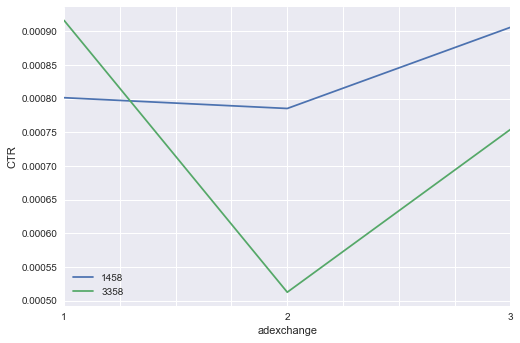

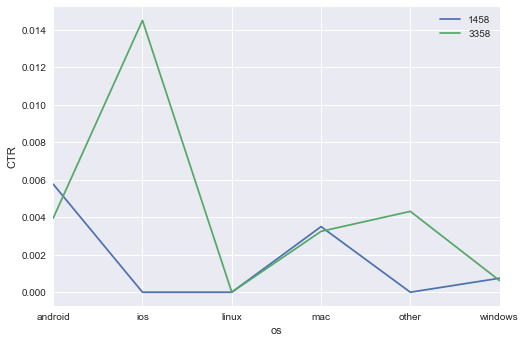

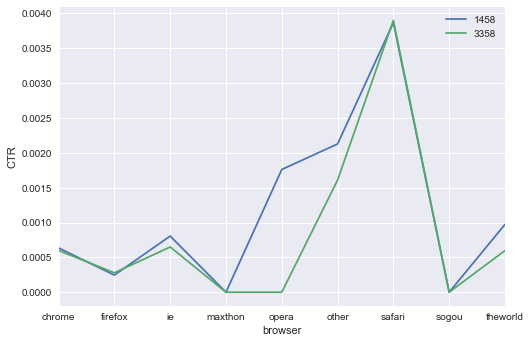

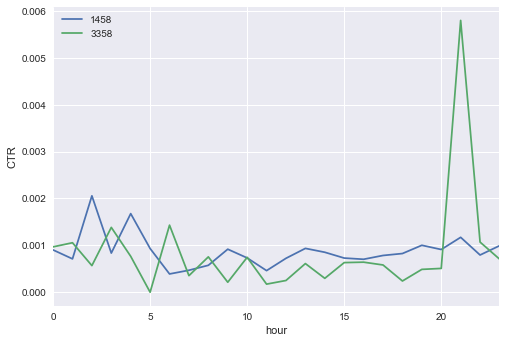

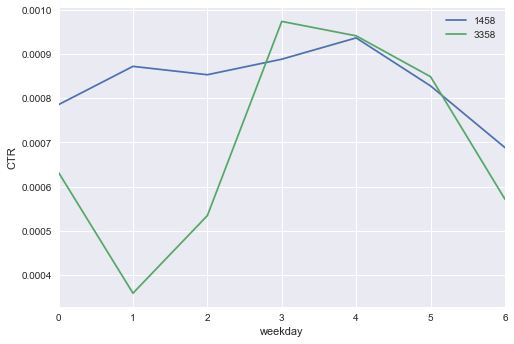

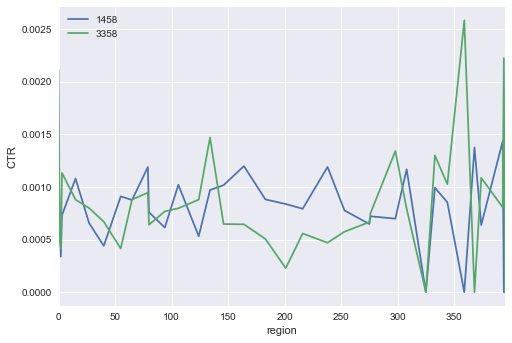

In [91]:
plot_ctr(1458,3358,'adexchange')

plot_ctr(1458,3358,'os')

plot_ctr(1458,3358,'browser')

plot_ctr(1458,3358,'hour')

plot_ctr(1458,3358,'weekday')

plot_ctr(1458,3358,'region')

# payprice(market price) against different features

In [37]:
def plot_payprice(advertiser1,advertiser2,category):
 
    df_clicked1 = df_train_original.ix[(df_train_original['advertiser']==advertiser1)]
    
    cost_weekday1 = df_clicked1['payprice'].groupby(df_train_original[category])

    dfeCPC1 = pd.DataFrame(cost_weekday1.mean()).rename(columns={'payprice':advertiser1})
    
    df_clicked2 = df_train_original.ix[(df_train_original['advertiser']==advertiser2)]

    cost_weekday2 = df_clicked2['payprice'].groupby(df_train_original[category])

    dfeCPC2 = pd.DataFrame(cost_weekday2.mean()).rename(columns={'payprice':advertiser2})
    
    plt.figure
    pd.concat([dfeCPC1,dfeCPC2],axis=1).plot()
    plt.ylabel('Price')

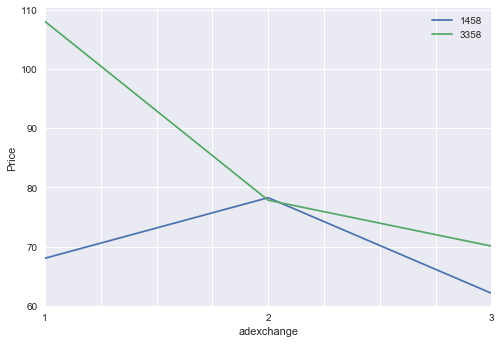

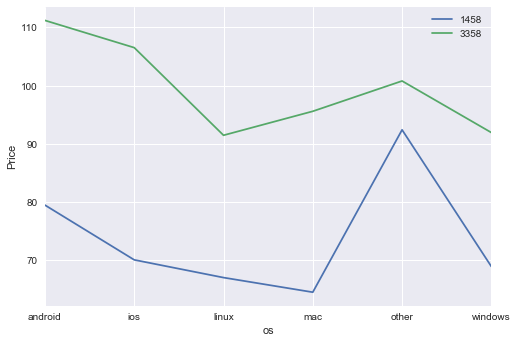

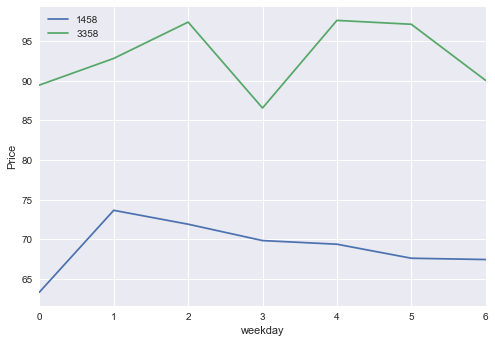

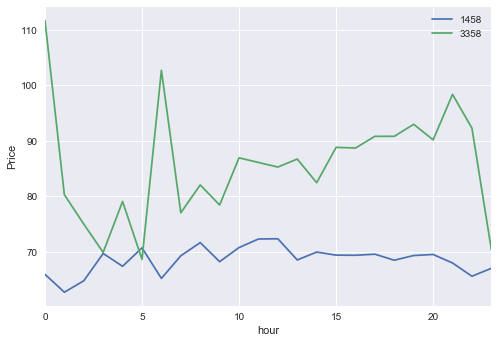

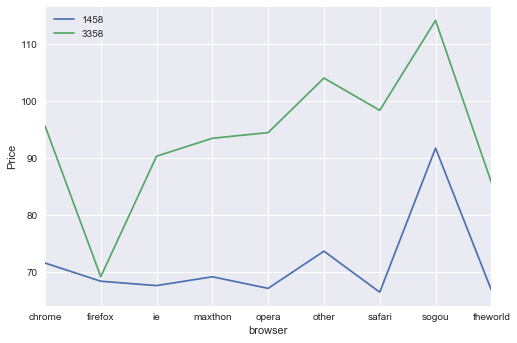

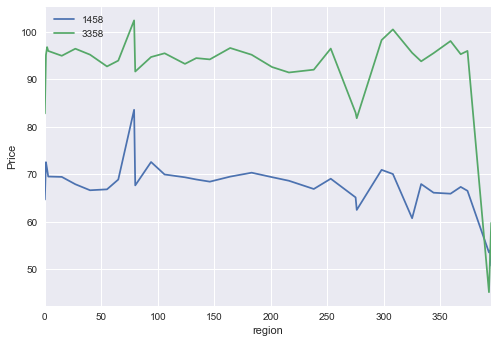

In [90]:
plot_payprice(1458,3358,'adexchange')

plot_payprice(1458,3358,'os')

plot_payprice(1458,3358,'weekday')

plot_payprice(1458,3358,'hour')

plot_payprice(1458,3358,'browser')

plot_payprice(1458,3358,'region')

# eCPC against different features

In [77]:
def calc_eCPC(advertiser,category):
    df_clicked = df_train_original.ix[(df_train_original['click']==1)]

    cost_weekday = df_train_original['payprice'].groupby(df_train_original[category])
    click_weekday = df_clicked['click'].groupby(df_train_original[category])

    dfeCPC = pd.DataFrame((cost_weekday.sum()/click_weekday.sum())/1000).rename(columns={0:'eCPC'})
    
    plt.figure
    dfeCPC.plot.bar(legend=False)
    plt.ylabel('eCPC')

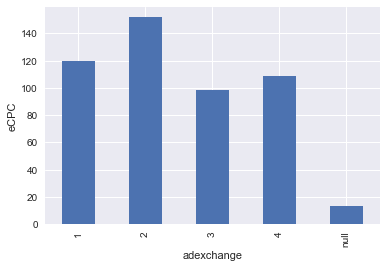

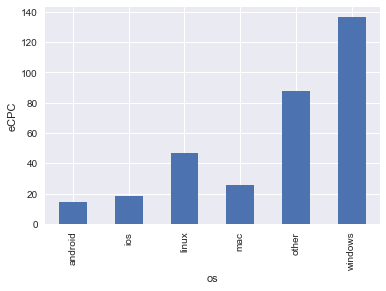

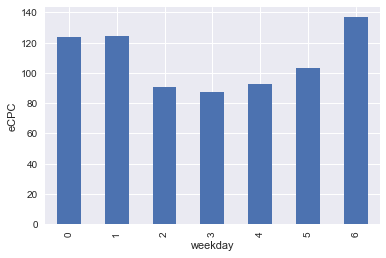

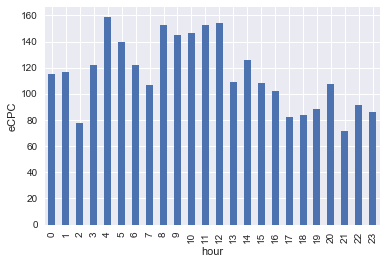

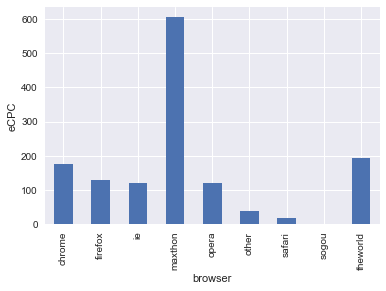

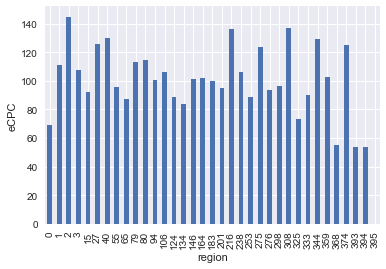

In [78]:
calc_eCPC(3358,'adexchange')

calc_eCPC(3358,'os')

calc_eCPC(3358,'weekday')

calc_eCPC(3358,'hour')

calc_eCPC(3358,'browser')

calc_eCPC(3358,'region')

# Bidding Strategy

## Constant strategy

In [577]:
def constant_bidding(constant):
    ad_go_through = -1
    impression = 0.0
    clicks = 0
    cost = 0.0
    budget = 25000000
    
    budget = budget / 4
    
    for click, pay_price in df_validation_original[['click','payprice']].values:
        ad_go_through += 1
        if constant > pay_price:
            impression += 1.0
            clicks += click
            cost += pay_price
        if cost >= budget:
            break
    return impression, clicks, cost, ad_go_through

In [564]:
const = pd.DataFrame()
const['constants'] = np.arange(0,302,2)

im = []
clks = []
ct = []
agt = []
for con in const['constants']:
    [imps, clicks, cost,ad_go_through] = constant_bidding(con)
    im.append(imps)
    clks.append(clicks)
    ct.append(cost)
    agt.append(ad_go_through)

In [565]:
const['imps_won'] = im
const['total_spend'] = ct
# const['cost'] = cc
const['clicks'] = clks
const['ad_go_through'] = agt
const['CTR'] = const['clicks']/const['imps_won']
const['eCPC'] = (const['total_spend']/const['clicks'])/1000
const['CPM'] =  const['total_spend']/const['imps_won']
const = const.set_index('constants')

In [566]:
def eva_plot(dataframe, xlabel):
    pic = plt.figure(figsize=(11,11))
    pic1 =pic.add_subplot(2,2,1)
    dataframe['clicks'].plot()
    plt.ylabel('Clicks')
    plt.xlabel(xlabel)

    pic2 =pic.add_subplot(2,2,2)
    dataframe['CTR'].plot()
    plt.ylabel('CTR')
    plt.xlabel(xlabel)

    pic3 =pic.add_subplot(2,2,3)
    dataframe['eCPC'].plot()
    plt.ylabel('eCPC')
    plt.xlabel(xlabel)

    pic4 =pic.add_subplot(2,2,4)
    dataframe['CPM'].plot()
    plt.ylabel('CPM')
    plt.xlabel(xlabel)

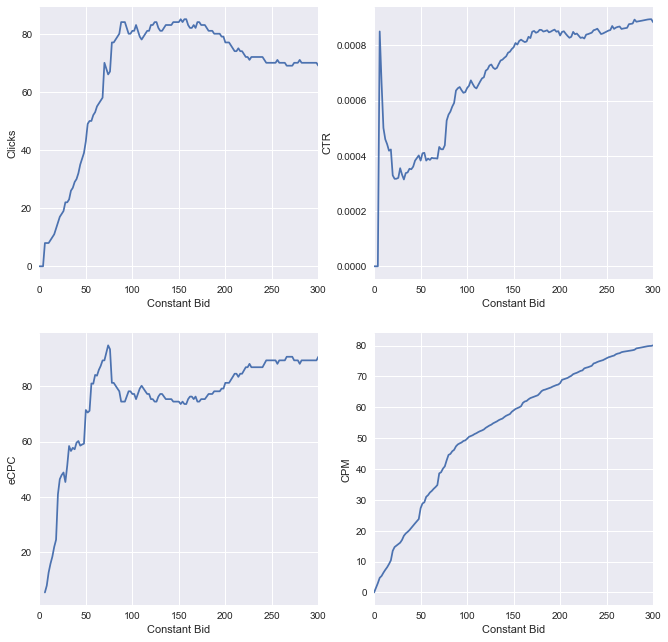

In [567]:
eva_plot(const,'Constant Bid')

In [568]:
const.ix[(const['clicks']==const['clicks'].max())]

,imps_won,total_spend,clicks,ad_go_through,CTR,eCPC,CPM
constants,,,,,,,
152,105117.0,6250019.0,85,122454,0.000809,73.529635,59.457738
156,104179.0,6250027.0,85,120674,0.000816,73.529729,59.993156
158,103566.0,6250026.0,85,119533,0.000821,73.529718,60.348242


In [569]:
const.ix[(const['CTR']==const['CTR'].max())]

,imps_won,total_spend,clicks,ad_go_through,CTR,eCPC,CPM
constants,,,,,,,
298,78228.0,6250065.0,70,78286,0.000895,89.286643,79.895498


In [571]:
df_val_const = df_validation_original.copy()

In [618]:
df_val_const['bidprice'] = 88

In [619]:
evaluate_result(df_val_const[:97549])

,click,Imps,cost,CPM,CTR,eCPC
advertiser,,,,,,
1458,14.0,15797.0,762.518,48.27,0.089%,54.47
2259,1.0,3133.0,122.636,39.14,0.032%,122.64
2261,2.0,2560.0,91.288,35.66,0.078%,45.64
2821,2.0,5026.0,191.034,38.01,0.04%,95.52
2997,4.0,1463.0,47.923,32.76,0.273%,11.98
3358,3.0,6213.0,298.679,48.07,0.048%,99.56
3386,7.0,13497.0,641.234,47.51,0.052%,91.60
3427,12.0,10531.0,506.942,48.14,0.114%,42.25
3476,9.0,9265.0,462.691,49.94,0.097%,51.41


## Random Strategy

In [443]:
from random import randrange
def random_bidding(upperbound):
    ad_go_through = -1
    impression = 0.0
    clicks = 0
    cost = 0.0
#     click_cost = 0.0
    budget = 25000 * 1000
    
    budget = budget / 4
    
    for click, pay_price in df_validation_original[['click','payprice']].values:
        bidprice = randrange(0,upperbound)
        ad_go_through += 1
        if bidprice > pay_price:
            impression += 1.0
            clicks += click
            cost += pay_price
        if cost >= budget:
            break
    return impression, clicks, cost, ad_go_through

In [444]:
random = pd.DataFrame()
random['upperbound'] = np.arange(2,302,2)

im = []
clks = []
ct = []
agt = []
# cc = []
for rand in random['upperbound']:
    [imps, clicks, cost, ad_go_through] = random_bidding(rand)
    im.append(imps)
    clks.append(clicks)
    ct.append(cost)
#     cc.append(click_cost)
    agt.append(ad_go_through)

In [445]:
random['imps_won'] = im
random['total_spend'] = ct
# random['cost'] = cc
random['clicks'] = clks
random['ad_go_through'] = agt
random['CTR'] = random['clicks']/random['imps_won']
random['eCPC'] = (random['total_spend']/random['clicks'])/1000
random['CPM'] = random['total_spend']/random['imps_won']
random = random.set_index('upperbound')

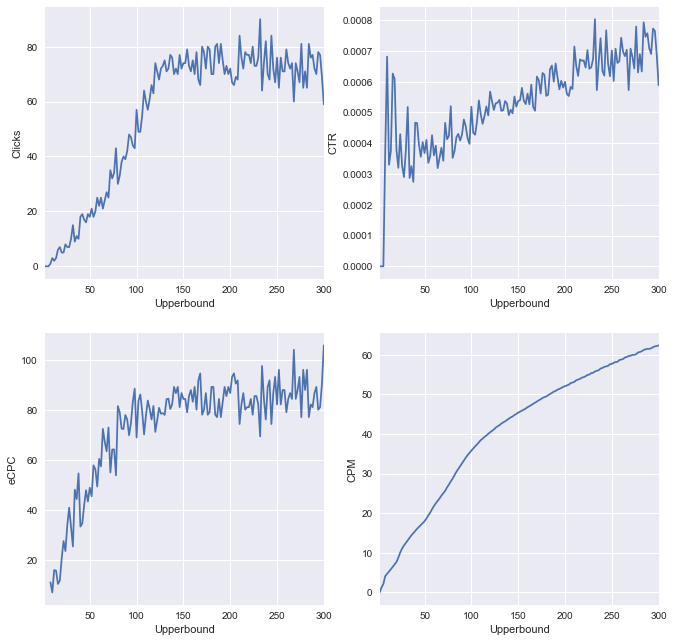

In [446]:
eva_plot(random,'Upperbound')

In [447]:
random.ix[(random['clicks']==random['clicks'].max())]

,imps_won,total_spend,clicks,ad_go_through,CTR,eCPC,CPM
upperbound,,,,,,,
232,112058.0,6250029.0,90,171705,0.000803,69.444767,55.774947


In [448]:
random.ix[(random['CTR']==random['CTR'][:].max())]

,imps_won,total_spend,clicks,ad_go_through,CTR,eCPC,CPM
upperbound,,,,,,,
232,112058.0,6250029.0,90,171705,0.000803,69.444767,55.774947


In [331]:
df_val_rand = df_validation_original.copy()

In [633]:
random_list = [randrange(0,168) for i in range(len(df_validation_original))]

In [634]:
df_val_rand['bidprice'] = random_list

In [635]:
evaluate_result(df_val_rand[:118568])

,click,Imps,cost,CPM,CTR,eCPC
advertiser,,,,,,
1458,12.0,14268.0,671.188,47.04,0.084%,55.93
2259,3.0,3183.0,135.538,42.58,0.094%,45.18
2261,2.0,2663.0,101.852,38.25,0.075%,50.93
2821,2.0,5257.0,218.044,41.48,0.038%,109.02
2997,3.0,1553.0,54.516,35.10,0.193%,18.17
3358,2.0,6478.0,351.836,54.31,0.031%,175.92
3386,5.0,12699.0,602.711,47.46,0.039%,120.54
3427,12.0,10699.0,557.616,52.12,0.112%,46.47
3476,6.0,8504.0,423.006,49.74,0.071%,70.50


## Linear strategy

In [661]:
# group_t =df_train_original.groupby('advertiser').sum()

In [662]:
# group_t['1/eCPC'] = group_t['click']/group_t['payprice']

In [660]:
# group_t['portion'] = group_t['1/eCPC'] / group_t['1/eCPC'].sum()
# group_t

,click,weekday,hour,logtype,region,city,slotwidth,slotheight,slotprice,bidprice,payprice,1/eCPC,portion
advertiser,,,,,,,,,,,,,
1458,451,1619852,7590685,540293,77974781,80684945,322379786,110521980,15271374,162087900,37231239,0.000012,0.091370
2259,45,455924,1540185,146778,31704048,32707361,74279068,28250370,3615396,42288044,13649026,0.000003,0.024868
2261,37,531400,1442088,120619,16943924,17464225,60003679,26229065,3223072,34725172,10789152,0.000003,0.025867
2821,144,151806,3715050,231416,32692416,33772485,141614202,42812220,5421799,67161076,20625766,0.000007,0.052661
2997,251,192624,934708,54487,8322619,8566371,17435840,2724350,1853120,15092899,3413227,0.000074,0.554679
3358,233,985970,3667205,304782,46602394,48081059,169569034,60263930,5119362,70940083,28145288,0.000008,0.062443
3386,358,1496773,6871877,498554,72431348,74871299,289702752,91452960,14699725,149566200,38341028,0.000009,0.070429
3427,340,1412606,6233567,454031,66341694,68599585,279496546,80995770,13045946,107242176,36820111,0.000009,0.069651
3476,175,952625,4332311,346778,50162115,51766045,198459390,66349320,9199370,85917235,27481402,0.000006,0.048032


### Validation

In [101]:
# predbid = basebid * pCTR / avgCTR

In [981]:
df_val_pctr['advertiser'] = df_validation_original['advertiser']

In [982]:
def div(data):
    return data['pCTR']/all_avgCTR[data['advertiser']]

In [983]:
df_val_pctr['division'] = df_val_pctr.apply(div,axis=1)

In [999]:
def linear_bidding(constant,adv):
    ad_go_through = -1
    impression = 0.0
    clicks = 0
    cost = 0.0
    budget = 25000000
    
    budget = budget / 4
    
    
    
    if adv == 1458:
        budget = 0.091370*budget
    if adv == 2259:
        budget = 0.024868*budget  
    if adv == 2261:
        budget = 0.025867*budget  
    if adv == 2821:
        budget = 0.052661*budget
    if adv == 2997:
        budget = 0.554679*budget  
    if adv == 3358:
        budget = 0.062443*budget
    if adv == 3386:
        budget = 0.070429*budget
    if adv == 3427:
        budget = 0.069651*budget  
    if adv == 3476:
        budget = 0.048032*budget
           
    for click, pay_price in df_validation_original.ix[(df_validation_original['advertiser']==adv)][['click','payprice']].values:
        ad_go_through += 1
        if constant[ad_go_through] > pay_price:
            impression += 1.0
            clicks += click
            cost += pay_price
        if cost >= budget:
            break
    return impression, clicks, cost, ad_go_through

In [1000]:
# def linear_bidding(constant,adv):
#     ad_go_through = -1
#     impression = 0.0
#     clicks = 0
#     cost = 0.0
#     budget = 25000000
    
#     budget = budget / 4
    
    
    
#     if adv == 1458:
#         budget = float(37231239)/216496239*budget
#     if adv == 2259:
#         budget = float(13649026)/216496239*budget  
#     if adv == 2261:
#         budget = float(10789152)/216496239*budget  
#     if adv == 2821:
#         budget = float(20625766)/216496239*budget
#     if adv == 2997:
#         budget = float(3413227)/216496239*budget  
#     if adv == 3358:
#         budget = float(28145288)/216496239*budget
#     if adv == 3386:
#         budget = float(38341028)/216496239*budget
#     if adv == 3427:
#         budget = float(36820111)/216496239*budget  
#     if adv == 3476:
#         budget = float(27481402)/216496239*budget
           
#     for click, pay_price in df_validation_original.ix[(df_validation_original['advertiser']==adv)][['click','payprice']].values:
#         ad_go_through += 1
#         if constant[ad_go_through] > pay_price:
#             impression += 1.0
#             clicks += click
#             cost += pay_price
#         if cost >= budget:
#             break
#     return impression, clicks, cost, ad_go_through

In [1001]:
bp = {}
basebid = {}
adv_list_linear = {}
for adv in df_train['advertiser'].unique():
    
    const = pd.DataFrame()
    const['base_bid'] = np.arange(0,302,2)

    im = []
    clks = []
    ct = []
    agt = []
    for base_bid in const['base_bid']:

        bid_price = base_bid * df_val_pctr.ix[(df_val_pctr['advertiser']==adv)]['division']

        [imps, clicks, cost, ad_go_through] = linear_bidding(bid_price.reset_index(drop=1),adv)
        im.append(imps)
        clks.append(clicks)
        ct.append(cost)
        agt.append(ad_go_through)
    const['imps_won'] = im
    const['total_spend'] = ct
    const['clicks'] = clks
    const['ad_go_through'] = agt
    const['CTR'] = const['clicks']/const['imps_won']
    const = const.set_index('base_bid')
    
    adv_list_linear[adv] = const
    basebid[adv] = const.ix[(const['clicks']==const['clicks'].max())].reset_index()['base_bid'][0]
    bp[adv] = basebid[adv] * df_val_pctr.ix[(df_val_pctr['advertiser']==adv)]['division']

In [1002]:
# val_pred_bid_price_1_4 = val_pred_bid_price.copy()

In [1003]:
# val_pred_bid_price_1_8 = val_pred_bid_price.copy()

In [1004]:
# val_pred_bid_price_1_2 = val_pred_bid_price.copy()

In [1005]:
# df_val_linear_1_4_ecpc = df_val_linear.copy()

In [1006]:
# df_val_linear_1_4_cost = df_val_linear.copy()

In [1007]:
val_pred_bid_price = pd.concat([bp[1458],bp[3476],bp[3427],bp[3358],bp[2259],bp[2821],bp[3386],bp[2997],bp[2261]]).sort_index()

In [1008]:
basebid

{1458: 136,
 2259: 46,
 2261: 74,
 2821: 44,
 2997: 240,
 3358: 50,
 3386: 36,
 3427: 78,
 3476: 60}

In [1009]:
df_val_linear = df_validation_original.copy()

In [1010]:
df_val_linear['bidprice'] = val_pred_bid_price

In [1011]:
ad_go_through = -1
impression = 0.0
clicks = 0
cost = 0.0
budget = 25000 * 1000

budget = budget/4

for click, pay_price in df_validation_original[['click','payprice']].values:
    ad_go_through += 1
    if val_pred_bid_price[ad_go_through] > pay_price:
        impression += 1.0
        clicks += click
        cost += pay_price
    if cost >= budget:
        break
    if ad_go_through == 299749:
        break

In [1012]:
linear_report = {}
linear_report.update({"click":clicks})
linear_report.update({"impression":impression})
linear_report.update({"ad_go_through":ad_go_through})
linear_report.update({"Total_spend":cost})
# linear_report.update({"cost":click_cost})
linear_report.update({"CTR":clicks/impression})
linear_report.update({"CPM":cost/impression})

In [1013]:
linear_report

{'CPM': 46.134874520954384,
 'CTR': 0.0009271850661392014,
 'Total_spend': 5970960.0,
 'ad_go_through': 299748,
 'click': 120,
 'impression': 129424.0}

In [1014]:
evaluate_result(df_val_linear[:linear_report['ad_go_through']])

,click,Imps,cost,CPM,CTR,eCPC
advertiser,,,,,,
1458,35.0,48846.0,2594.313,53.11,0.072%,74.12
2259,4.0,4380.0,135.818,31.01,0.091%,33.95
2261,3.0,6416.0,258.602,40.31,0.047%,86.20
2821,5.0,8150.0,259.526,31.84,0.061%,51.91
2997,22.0,5425.0,284.096,52.37,0.406%,12.91
3358,8.0,8095.0,334.468,41.32,0.099%,41.81
3386,10.0,10569.0,335.695,31.76,0.095%,33.57
3427,23.0,21602.0,1027.767,47.58,0.106%,44.69
3476,10.0,15940.0,740.663,46.47,0.063%,74.07


# Compare constant, random and linear strategy

In [116]:
def test_performance(bidding_strategy,portion_of_budget):
    ad_go_through = -1
    clicks = 0
    cost = 0.0
    budget = 25000 * 1000

    budget = budget * portion_of_budget

    for click, pay_price in df_validation_original[['click','payprice']].values:
        ad_go_through += 1
        if bidding_strategy['bidprice'][ad_go_through] > pay_price:
            cost += pay_price
        if cost >= budget:
            break
        if ad_go_through == 299749:
            break

#     return ad_go_through
    return evaluate_result(bidding_strategy[:ad_go_through])

## 1/2 budget

In [287]:
# const bid = 130
# agt = 
const_1_2_result = test_performance(df_val_const,0.5)
const_1_2_result

,click,Imps,cost,CPM,CTR,eCPC
advertiser,,,,,,
1458,33.0,49126,2577,52.47,0.067%,78.11
2259,5.0,10672,537,50.33,0.047%,107.43
2261,2.0,8859,416,46.96,0.023%,208.01
2821,7.0,17205,838,48.72,0.041%,119.75
2997,14.0,4742,197,41.60,0.295%,14.09
3358,16.0,24456,1553,63.52,0.065%,97.08
3386,23.0,42974,2328,54.19,0.054%,101.24
3427,32.0,39385,2371,60.22,0.081%,74.12
3476,13.0,30219,1736,57.47,0.043%,133.60


In [324]:
# rand ub = 252
# agt = all
rand_1_2_result = test_performance(df_val_rand,0.5)
rand_1_2_result

,click,Imps,cost,CPM,CTR,eCPC
advertiser,,,,,,
1458,31.0,43686,2345,53.70,0.071%,75.67
2259,5.0,10437,619,59.40,0.048%,124.00
2261,3.0,8690,476,54.84,0.035%,158.84
2821,9.0,16619,936,56.38,0.054%,104.10
2997,14.0,4485,194,43.35,0.312%,13.89
3358,11.0,21354,1434,67.18,0.052%,130.41
3386,21.0,38635,2177,56.36,0.054%,103.69
3427,28.0,34316,2127,62.00,0.082%,75.98
3476,10.0,26669,1593,59.76,0.037%,159.38


In [528]:
linear_1_2_result = test_performance(df_val_linear,0.5)
linear_1_2_result

,click,Imps,cost,CPM,CTR,eCPC
advertiser,,,,,,
1458,35.0,48619,2782,57.23,0.072%,79.50
2259,6.0,9949,653,65.69,0.06%,108.93
2261,4.0,8696,530,60.97,0.046%,132.56
2821,10.0,16855,1028,61.05,0.059%,102.90
2997,14.0,4116,154,37.60,0.34%,11.06
3358,15.0,19308,1235,64.00,0.078%,82.38
3386,21.0,35746,2000,55.97,0.059%,95.28
3427,36.0,34448,2136,62.01,0.105%,59.34
3476,13.0,29905,1977,66.12,0.043%,152.10


## 1/4 budget

In [299]:
# const bid = 160
# agt = evaluate_result(df_val_const[:119237])
const_1_4_result = test_performance(df_val_const,0.25)
const_1_4_result 

,click,Imps,cost,CPM,CTR,eCPC
advertiser,,,,,,
1458,21.0,22139,1277,57.70,0.095%,60.83
2259,4.0,5301,344,64.90,0.075%,86.01
2261,2.0,4112,231,56.37,0.049%,115.89
2821,3.0,8255,492,59.65,0.036%,164.15
2997,8.0,2171,103,47.70,0.368%,12.94
3358,7.0,11228,778,69.36,0.062%,111.25
3386,10.0,19757,1174,59.45,0.051%,117.46
3427,20.0,17705,1145,64.69,0.113%,57.27
3476,11.0,13772,867,63.01,0.08%,78.89


In [285]:
rand_1_4_result = test_performance(df_val_rand,0.25)
rand_1_4_result 

,click,Imps,cost,CPM,CTR,eCPC
advertiser,,,,,,
1458,19.0,24572,1287,52.40,0.077%,67.77
2259,4.0,5682,311,54.80,0.07%,77.84
2261,1.0,4740,241,50.92,0.021%,241.36
2821,2.0,9142,479,52.48,0.022%,239.87
2997,6.0,2533,102,40.40,0.237%,17.06
3358,8.0,11802,754,63.95,0.068%,94.35
3386,8.0,21334,1148,53.86,0.037%,143.62
3427,13.0,18952,1125,59.37,0.069%,86.55
3476,9.0,14871,851,57.24,0.061%,94.58


In [679]:
# real
linear_1_4_result = test_performance(df_val_linear,0.25)
linear_1_4_result 

,click,Imps,cost,CPM,CTR,eCPC
advertiser,,,,,,
1458,35.0,48846.0,2594.313,53.11,0.072%,74.12
2259,4.0,4380.0,135.818,31.01,0.091%,33.95
2261,3.0,6416.0,258.602,40.31,0.047%,86.20
2821,5.0,8150.0,259.526,31.84,0.061%,51.91
2997,22.0,5425.0,284.096,52.37,0.406%,12.91
3358,8.0,8095.0,334.468,41.32,0.099%,41.81
3386,10.0,10569.0,335.695,31.76,0.095%,33.57
3427,23.0,21602.0,1027.767,47.58,0.106%,44.69
3476,10.0,15940.0,740.663,46.47,0.063%,74.07


## 1/8 budget

In [311]:
# const bid = 88
# adg = evaluate_result(df_val_const[:97549])
const_1_8_result = test_performance(df_val_const,0.125)
const_1_8_result 

,click,Imps,cost,CPM,CTR,eCPC
advertiser,,,,,,
1458,14.0,15835,765,48.37,0.088%,54.70
2259,1.0,3145,123,39.33,0.032%,123.69
2261,2.0,2568,91,35.82,0.078%,46.00
2821,2.0,5043,192,38.18,0.04%,96.27
2997,4.0,1467,48,32.91,0.273%,12.07
3358,3.0,6470,321,49.66,0.046%,107.10
3386,7.0,13533,644,47.62,0.052%,92.06
3427,13.0,11759,615,52.30,0.111%,47.31
3476,9.0,9302,465,50.09,0.097%,51.77


In [336]:
# rand ub = 168
# evaluate_result(df_val_rand[:118569])
rand_1_8_result = test_performance(df_val_rand,0.125)
rand_1_8_result 

,click,Imps,cost,CPM,CTR,eCPC
advertiser,,,,,,
1458,10.0,14443,682,47.27,0.069%,68.28
2259,3.0,3211,140,43.86,0.093%,46.94
2261,1.0,2712,108,39.83,0.037%,108.02
2821,1.0,5281,223,42.39,0.019%,223.87
2997,4.0,1584,55,35.07,0.253%,13.89
3358,3.0,6505,352,54.24,0.046%,117.62
3386,7.0,12600,596,47.32,0.056%,85.18
3427,14.0,10883,572,52.65,0.129%,40.93
3476,10.0,8529,429,50.37,0.117%,42.96


In [504]:
# real
linear_1_8_result = test_performance(df_val_linear,0.125)
linear_1_8_result 

,click,Imps,cost,CPM,CTR,eCPC
advertiser,,,,,,
1458,20.0,25720,1280,49.77,0.078%,64.00
2259,3.0,2482,76,30.63,0.121%,25.34
2261,3.0,3639,145,39.99,0.082%,48.51
2821,2.0,4686,149,31.90,0.043%,74.74
2997,4.0,1155,17,15.27,0.346%,4.41
3358,4.0,4607,189,41.12,0.087%,47.36
3386,7.0,8846,322,36.43,0.079%,46.04
3427,14.0,11420,519,45.46,0.123%,37.09
3476,10.0,9176,425,46.36,0.109%,42.54


In [238]:
const_1_result = test_performance(df_val_const,1)
const_1_result 

,click,Imps,cost,CPM,CTR,eCPC
advertiser,,,,,,
1458,37.0,52717,2771,52.57,0.07%,74.90
2259,6.0,11509,580,50.43,0.052%,96.73
2261,2.0,9527,449,47.14,0.021%,224.57
2821,8.0,18490,901,48.76,0.043%,112.70
2997,15.0,5091,212,41.73,0.295%,14.16
3358,17.0,26263,1666,63.47,0.065%,98.05
3386,26.0,46170,2503,54.23,0.056%,96.29
3427,33.0,42328,2549,60.24,0.078%,77.26
3476,13.0,32474,1867,57.50,0.04%,143.64


In [239]:
rand_1_result = test_performance(df_val_rand,1)
rand_1_result 

,click,Imps,cost,CPM,CTR,eCPC
advertiser,,,,,,
1458,27.0,40752,2074,50.91,0.066%,76.84
2259,4.0,9500,498,52.44,0.042%,124.55
2261,2.0,7998,388,48.58,0.025%,194.26
2821,6.0,15356,772,50.30,0.039%,128.72
2997,10.0,4247,168,39.63,0.235%,16.83
3358,11.0,19570,1201,61.38,0.056%,109.21
3386,18.0,35707,1877,52.59,0.05%,104.32
3427,19.0,31515,1821,57.81,0.06%,95.88
3476,9.0,24613,1364,55.42,0.037%,151.56


In [240]:
linear_1_result = test_performance(df_val_linear,1)
linear_1_result 

,click,Imps,cost,CPM,CTR,eCPC
advertiser,,,,,,
1458,48.0,56520,3502,61.97,0.085%,72.97
2259,9.0,10936,716,65.52,0.082%,79.61
2261,4.0,9499,580,61.08,0.042%,145.04
2821,13.0,20136,1356,67.39,0.065%,104.38
2997,22.0,5425,284,52.37,0.406%,12.91
3358,23.0,29079,2341,80.51,0.079%,101.79
3386,31.0,49868,3355,67.28,0.062%,108.24
3427,41.0,45042,3179,70.60,0.091%,77.55
3476,13.0,32630,2151,65.95,0.04%,165.53


# Final Strategy: ORTB

In [ ]:
########################################################

In [906]:
lambda_range = [1e-7,5e-7,1e-6,5e-6,1e-5,5e-5]
c_range = [20,50,80]

ortbbids = []
clambda = []

for c in c_range:
    for lambdas in lambda_range:
        clambda.append((c,lambdas))
        ortbbid = np.sqrt((c / lambdas * np.asarray(df_val_pctr.pCTR)+ c**2))  - c
        ortbbids.append(ortbbid.tolist())

In [936]:
def ORTB_bidding(df_copy,adv):
    ad_go_through = -1
    impression = 0.0
    clicks = 0
    cost = 0.0
#     click_cost = 0.0
    budget = 25000000
    
    budget = budget / 4
    
#     if adv == 1458:
#         budget = 0.091370*budget
#     if adv == 2259:
#         budget = 0.024868*budget  
#     if adv == 2261:
#         budget = 0.025867*budget  
#     if adv == 2821:
#         budget = 0.052661*budget
#     if adv == 2997:
#         budget = 0.554679*budget  
#     if adv == 3358:
#         budget = 0.062443*budget
#     if adv == 3386:
#         budget = 0.070429*budget
#     if adv == 3427:
#         budget = 0.069651*budget  
#     if adv == 3476:
#         budget = 0.048032*budget

    if adv == 1458:
        budget = float(37231239)/216496239*budget
    if adv == 2259:
        budget = float(13649026)/216496239*budget  
    if adv == 2261:
        budget = float(10789152)/216496239*budget  
    if adv == 2821:
        budget = float(20625766)/216496239*budget
    if adv == 2997:
        budget = float(3413227)/216496239*budget  
    if adv == 3358:
        budget = float(28145288)/216496239*budget
    if adv == 3386:
        budget = float(38341028)/216496239*budget
    if adv == 3427:
        budget = float(36820111)/216496239*budget  
    if adv == 3476:
        budget = float(27481402)/216496239*budget
           
        
    df_copy = df_copy.reset_index()
    for click, pay_price in df_validation_original.ix[(df_validation_original['advertiser']==adv)][['click','payprice']].values:
        ad_go_through += 1
        if df_copy['bidprice'][ad_go_through] > pay_price:
            impression += 1.0
            clicks += click
            cost += pay_price
        if cost >= budget:
            break
    return impression, clicks, cost, ad_go_through

In [937]:
# bp = {}
clambda_list = {}
# adv_list_linear = {}
for adv in df_train['advertiser'].unique():

    ortb = pd.DataFrame()
    ortb['C,Lambda'] = clambda

    im = []
    clks = []
    ct = []
    agt = []

    for bid in ortbbids:
        df_copy = df_validation_original.copy()
        df_copy['bidprice'] = bid
        df_copy = df_copy.ix[(df_copy['advertiser']==adv)]
        [imps, clicks, cost, ad_go_through] = ORTB_bidding(df_copy,adv)
        im.append(imps)
        clks.append(clicks)
        ct.append(cost)
        agt.append(ad_go_through)
        
#     ortb['imps_won'] = im
#     ortb['total_spend'] = ct
    ortb['clicks'] = clks
#     ortb['ad_go_through'] = agt
#     ortb['CTR'] = (ortb['clicks']/ortb['imps_won'] * 100).round(4).astype(str) + '%'
#     ortb['CPM'] = (ortb['total_spend']/ortb['imps_won']).round(2)
#     ortb['CPC'] = ((ortb['total_spend']/ortb['clicks'])/1000).round(2)
    clambda_list[adv] = ortb.iloc[np.where(ortb.clicks == ortb.clicks.max())[0]].index[0]

In [938]:
clambda_list

{1458: 0,
 2259: 1,
 2261: 0,
 2821: 2,
 2997: 11,
 3358: 1,
 3386: 15,
 3427: 2,
 3476: 1}

In [939]:
bp = {}
for adv in df_train['advertiser'].unique():
    df_copy = df_validation_original.copy()
    df_copy['bidprice'] = ortbbids[clambda_list[adv]]
    bp[adv] = df_copy.ix[(df_copy['advertiser']==adv)]

In [940]:
val_pred_bid_price_prtb = pd.concat([bp[1458],bp[3476],bp[3427],bp[3358],bp[2259],bp[2821],bp[3386],bp[2997],bp[2261]]).sort_index()

In [941]:
ad_go_through = -1
impression = 0.0
clicks = 0
cost = 0.0
budget = 25000 * 1000

budget = budget / 4

for click, pay_price in df_validation_original[['click','payprice']].values:
    ad_go_through += 1
    if val_pred_bid_price_prtb['bidprice'][ad_go_through] > pay_price:
        impression += 1.0
        clicks += click
        cost += pay_price
    if cost >= budget:
        break
    if ad_go_through == 299749:
        break

In [942]:
cost

6250005.0

In [943]:
ad_go_through

164869

In [945]:
# df_val_ortb_1_4_cost = val_pred_bid_price_prtb.copy()

In [944]:
# ortb_1_4_ecpc =
evaluate_result(val_pred_bid_price_prtb[:ad_go_through])
# ortb_1_4_ecpc

,click,Imps,cost,CPM,CTR,eCPC
advertiser,,,,,,
1458,29.0,32922.0,2239.829,68.03,0.088%,77.24
2259,3.0,4583.0,189.168,41.28,0.065%,63.06
2261,4.0,6133.0,428.288,69.83,0.065%,107.07
2821,2.0,8076.0,324.769,40.21,0.025%,162.38
2997,4.0,1358.0,23.766,17.50,0.295%,5.94
3358,11.0,13841.0,912.062,65.90,0.079%,82.91
3386,7.0,9606.0,317.731,33.08,0.073%,45.39
3427,19.0,18140.0,967.566,53.34,0.105%,50.92
3476,11.0,15578.0,846.756,54.36,0.071%,76.98


In [366]:
#
ortb_1_8_result = evaluate_result(df_val_ortb[:271453])

In [601]:
ortb_1_8_result

,click,Imps,cost,CPM,CTR,eCPC
advertiser,,,,,,
1458,14.0,25532,922,36.15,0.055%,65.92
2259,1.0,2538,52,20.59,0.039%,52.26
2261,1.0,2791,54,19.62,0.036%,54.77
2821,4.0,8077,241,29.84,0.05%,60.26
2997,16.0,4904,246,50.27,0.326%,15.41
3358,6.0,8197,316,38.58,0.073%,52.71
3386,11.0,15762,517,32.86,0.07%,47.09
3427,14.0,13539,488,36.06,0.103%,34.87
3476,6.0,8672,285,32.87,0.069%,47.51


In [378]:
#
ortb_1_4_result = evaluate_result(df_val_ortb[:199135])

In [418]:
ortb_1_4_result

,click,Imps,cost,CPM,CTR,eCPC
advertiser,,,,,,
1458,25.0,32195,1599,49.68,0.078%,63.97
2259,2.0,4089,133,32.75,0.049%,66.96
2261,2.0,3912,115,29.61,0.051%,57.93
2821,3.0,9769,394,40.36,0.031%,131.42
2997,14.0,3873,226,58.41,0.361%,16.16
3358,8.0,12836,711,55.45,0.062%,88.97
3386,11.0,24729,1212,49.04,0.044%,110.25
3427,21.0,21923,1169,53.34,0.096%,55.69
3476,10.0,14470,686,47.44,0.069%,68.64


In [419]:
ortb_1_2_result

,click,Imps,cost,CPM,CTR,eCPC
advertiser,,,,,,
1458,36.0,52216,2923,55.98,0.069%,81.20
2259,4.0,7358,296,40.28,0.054%,74.09
2261,2.0,6864,256,37.30,0.029%,128.02
2821,8.0,16966,874,51.57,0.047%,109.36
2997,24.0,5812,364,62.68,0.413%,15.18
3358,17.0,23670,1541,65.13,0.072%,90.68
3386,25.0,43370,2469,56.95,0.058%,98.80
3427,34.0,39050,2388,61.16,0.087%,70.25
3476,11.0,25850,1385,53.59,0.043%,125.95


In [389]:
#
ortb_1_2_result = evaluate_result(df_val_ortb[:291246])

# Compare all the strategies

## 1/2 budget

In [243]:
# bud_1 = pd.concat([
#     const_1_result.iloc[9].rename('const'),
#     rand_1_result.iloc[9].rename('rand'),
#     linear_1_result.iloc[9].rename('linear'),
#     ortb_1_result.iloc[9].rename('ortb')
# ],axis=1).transpose()
# # .to_csv('compare_1_2_result.csv')

In [531]:
# bud_1_2 = 
pd.concat([
    const_1_2_result.iloc[9].rename('const'),
    rand_1_2_result.iloc[9].rename('rand'),
    linear_1_2_result.iloc[9].rename('linear'),
    ortb_1_2_result.iloc[9].rename('ortb')
],axis=1).transpose()
# .to_csv('compare_1_2_result.csv')

,click,Imps,cost,CPM,CTR,eCPC
const,145,227638,12557,55.16,0.064%,86.60
rand,132,204891,11906,58.11,0.064%,90.20
linear,154,207642,12499,60.20,0.074%,81.17
ortb,161,221156,12499,56.52,0.073%,77.64


In [972]:
# bud_1_4 =
pd.concat([
    const_1_4_result.iloc[9].rename('const'),
    rand_1_4_result.iloc[9].rename('rand'),
    linear_cost.iloc[9].rename('linear'),
    ortb_ecpc.iloc[9].rename('ortb')
],axis=1).transpose()
# .to_csv('compare_1_4_result.csv')

In [508]:
# bud_1_8 = 
pd.concat([
    const_1_8_result.iloc[9].rename('const'),
    rand_1_8_result.iloc[9].rename('rand'),
    linear_1_8_result.iloc[9].rename('linear'),
    ortb_1_8_result.iloc[9].rename('ortb')
],axis=1).transpose()
# .to_csv('compare_1_8_result.csv')

,click,Imps,cost,CPM,CTR,eCPC
const,55,69122,3269,47.29,0.08%,59.44
rand,53,65748,3162,48.10,0.081%,59.67
linear,67,71731,3124,43.57,0.093%,46.64
ortb,73,90012,3124,34.72,0.081%,42.81


In [412]:
# pic=plt.figure(figsize=(12,9))
# alpha_level = 0.55

# pic1 = pic.add_subplot(2,3,1)
# bud_1['click'].plot(kind='bar',alpha=alpha_level)
# pic1.set_xticklabels(["const", "rand",'linear','ortb'], rotation=0)
# plt.title("Budget (1/1)")
# plt.ylabel('Total Clicks')

# pic2 = pic.add_subplot(2,3,2)   #share the same y axis with `pic1`
# bud_1_2['click'].plot(kind='bar',alpha=alpha_level)
# pic1.set_xticklabels(["const", "rand",'linear','ortb'], rotation=0)
# plt.title("Budget (1/2)")

# pic3 = pic.add_subplot(2,3,3)

# bud_1_4['click'].plot(kind='bar',alpha=alpha_level)
# pic2.set_xticklabels(["const", "rand",'linear','ortb'], rotation=0)
# plt.title("Budget (1/4)")

# pic4 = pic.add_subplot(2,3,4) 
# pd.to_numeric(bud_1['eCPC']).plot(kind='bar',alpha=alpha_level)
# pic4.set_xticklabels(["const", "rand",'linear','ortb'], rotation=0)
# plt.title("Budget (1/1)")
# plt.gca().set_ylim([40,100])
# plt.ylabel('eCPC')

# pic5 = pic.add_subplot(2,3,5)   #share the same y axis with `pic1`
# pd.to_numeric(bud_1_2['eCPC']).plot(kind='bar',alpha=alpha_level)
# pic4.set_xticklabels(["const", "rand",'linear','ortb'], rotation=0)
# plt.title("Budget (1/2)")
# plt.gca().set_ylim([40,100])

# pic6 = pic.add_subplot(2,3,6)
# pd.to_numeric(bud_1_4['eCPC']).plot(kind='bar',alpha=alpha_level)
# pic5.set_xticklabels(["const", "rand",'linear','ortb'], rotation=0)
# plt.title("Budget (1/4)")
# plt.gca().set_ylim([40,100])



(40, 100)

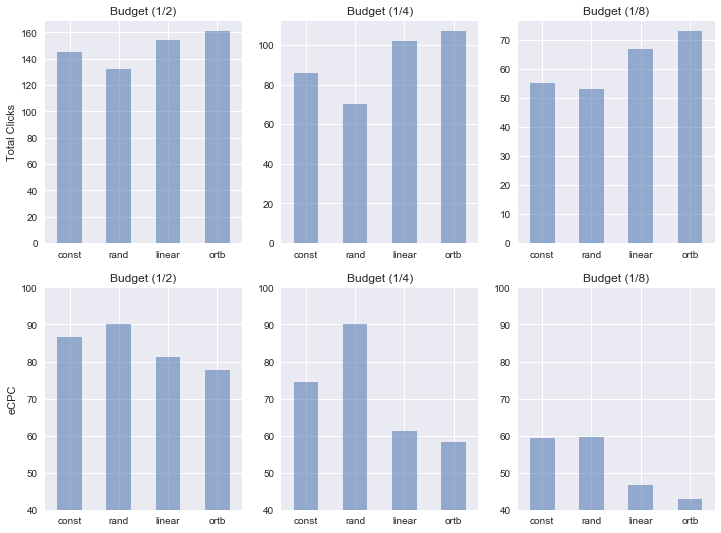

In [973]:
pic=plt.figure(figsize=(12,9))
alpha_level = 0.55

pic1 = pic.add_subplot(2,3,1)


bud_1_2['click'].plot(kind='bar',alpha=alpha_level)
pic1.set_xticklabels(["const", "rand",'linear','ortb'], rotation=0)
plt.title("Budget (1/2)")
plt.ylabel('Total Clicks')

pic2 = pic.add_subplot(2,3,2)   #share the same y axis with `pic1`

bud_1_4['click'].plot(kind='bar',alpha=alpha_level)
pic2.set_xticklabels(["const", "rand",'linear','ortb'], rotation=0)
plt.title("Budget (1/4)")

pic3 = pic.add_subplot(2,3,3)

bud_1_8['click'].plot(kind='bar',alpha=alpha_level)
pic3.set_xticklabels(["const", "rand",'linear','ortb'], rotation=0)
plt.title("Budget (1/8)")

pic4 = pic.add_subplot(2,3,4) 
pd.to_numeric(bud_1_2['eCPC']).plot(kind='bar',alpha=alpha_level)
pic4.set_xticklabels(["const", "rand",'linear','ortb'], rotation=0)
plt.title("Budget (1/2)")
plt.gca().set_ylim([40,100])
plt.ylabel('eCPC')

pic5 = pic.add_subplot(2,3,5)   #share the same y axis with `pic1`

pd.to_numeric(bud_1_4['eCPC']).plot(kind='bar',alpha=alpha_level)
pic5.set_xticklabels(["const", "rand",'linear','ortb'], rotation=0)
plt.title("Budget (1/4)")
plt.gca().set_ylim([40,100])

pic6 = pic.add_subplot(2,3,6)

pd.to_numeric(bud_1_8['eCPC']).plot(kind='bar',alpha=alpha_level)
pic6.set_xticklabels(["const", "rand",'linear','ortb'], rotation=0)
plt.title("Budget (1/8)")
plt.gca().set_ylim([40,100])


In [511]:
val_pred_bid_price_1_4[:5]

0     37.284370
1     48.313616
2    119.108105
3     77.402952
4     59.631773
Name: division, dtype: float64

In [512]:
val_pred_bid_price_1_8[:5]

0     32.737496
1     21.657828
2    104.582726
3     67.963568
4     47.705419
Name: division, dtype: float64

# ORTB vs Linear

In [ ]:
linear_1_4_result

In [ ]:
ortb_1_4_result

### Test

In [1015]:
df_test_pctr['advertiser'] = df_test_original['advertiser']

In [1016]:
df_test_pctr['division'] = df_test_pctr.apply(div,axis=1)

In [1017]:
bp_test = {}
for adv in df_train['advertiser'].unique():
    bp_test[adv] = basebid[adv] * df_test_pctr.ix[(df_test_pctr['advertiser']==adv)]['division']
test_pred_bid_price = pd.concat([bp_test[1458],bp_test[3476],bp_test[3427],bp_test[3358],bp_test[2259],bp_test[2821],bp_test[3386],bp_test[2997],bp_test[2261]]).sort_index()    

# Output file

In [1018]:
df_pred = pd.DataFrame(test_pred_bid_price.tolist(), index = df_test_original["bidid"], columns=["bidprice"])

In [1019]:
# df_pred.to_csv('testing_bidding_price.csv', header=True, index_label='bidid')

In [1020]:
df_pred.to_csv('Final_testing_bidding_price.csv', header=True, index_label='bidid')

In [1021]:
df_pred

,bidprice
bidid,
fe2e06dff1dfd227471fd1ca717888ac,73.181431
92ea762b7b2cfd7aee30a2e88e1f5899,82.386003
617dfab714eedf4988c4aa9ad5425eca,63.510216
7fa016aaa3db39413b482f757facc3f4,33.274025
49db062ac10d19591dc7d988d730aad5,74.817970
6d86a43fbda12fc89c98620f4d8aedc1,45.342619
3b6b3f3227d42ad74971be4b9a26c189,17.648238
2cc65c3a9f97620d33d4c3ddfb368869,87.509817
be487ced968062be378892fc87013ff9,124.010770


In [425]:
rand_1_4_result.to_csv('rand_1_4_result.csv')

In [426]:
const_1_4_result.to_csv('const_1_4_result.csv')

In [602]:
linear_1_4_result.to_csv('linear_1_4_result.csv')

In [428]:
ortb_1_4_result.to_csv('ortb_1_4_result.csv')

In [967]:
ortb_ecpc.to_csv('ortb_ecpc.csv')

In [935]:
ortb_ecpc = evaluate_result(df_val_ortb_1_4_ecpc[:206286])
ortb_ecpc

,click,Imps,cost,CPM,CTR,eCPC
advertiser,,,,,,
1458,38.0,41300.0,2805.957,67.94,0.092%,73.84
2259,3.0,5751.0,236.337,41.09,0.052%,78.78
2261,3.0,6101.0,309.652,50.75,0.049%,103.22
2821,2.0,5596.0,155.394,27.77,0.036%,77.70
2997,16.0,4143.0,263.649,63.64,0.386%,16.48
3358,6.0,6187.0,237.872,38.45,0.097%,39.65
3386,7.0,10668.0,316.746,29.69,0.066%,45.25
3427,22.0,22707.0,1211.999,53.38,0.097%,55.09
3476,10.0,15008.0,712.391,47.47,0.067%,71.24


In [974]:
# linear_ecpc.to_csv('Optimal_Lin.csv')

In [948]:
linear_ecpc = evaluate_result(df_val_linear_1_4_ecpc[:299748])
linear_ecpc

,click,Imps,cost,CPM,CTR,eCPC
advertiser,,,,,,
1458,35.0,48846.0,2594.313,53.11,0.072%,74.12
2259,4.0,4380.0,135.818,31.01,0.091%,33.95
2261,3.0,6416.0,258.602,40.31,0.047%,86.20
2821,5.0,8150.0,259.526,31.84,0.061%,51.91
2997,22.0,5425.0,284.096,52.37,0.406%,12.91
3358,8.0,8095.0,334.468,41.32,0.099%,41.81
3386,10.0,10569.0,335.695,31.76,0.095%,33.57
3427,23.0,21602.0,1027.767,47.58,0.106%,44.69
3476,10.0,15940.0,740.663,46.47,0.063%,74.07


In [904]:
df_val_ortb_1_4_cost

In [946]:
ortb_cost

,click,Imps,cost,CPM,CTR,eCPC
advertiser,,,,,,
1458,29.0,32922.0,2239.829,68.03,0.088%,77.24
2259,3.0,4583.0,189.168,41.28,0.065%,63.06
2261,4.0,6133.0,428.288,69.83,0.065%,107.07
2821,2.0,8076.0,324.769,40.21,0.025%,162.38
2997,4.0,1358.0,23.766,17.50,0.295%,5.94
3358,11.0,13841.0,912.062,65.90,0.079%,82.91
3386,7.0,9606.0,317.731,33.08,0.073%,45.39
3427,19.0,18140.0,967.566,53.34,0.105%,50.92
3476,11.0,15578.0,846.756,54.36,0.071%,76.98


In [899]:
linear_cost = evaluate_result(df_val_linear_1_4_cost[:207347])
linear_cost

,click,Imps,cost,CPM,CTR,eCPC
advertiser,,,,,,
1458,36.0,39170.0,2414.969,61.65,0.092%,67.08
2259,4.0,5370.0,260.000,48.42,0.074%,65.00
2261,4.0,6567.0,403.486,61.44,0.061%,100.87
2821,4.0,9256.0,405.942,43.86,0.043%,101.49
2997,7.0,2354.0,61.486,26.12,0.297%,8.78
3358,7.0,7542.0,355.073,47.08,0.093%,50.72
3386,10.0,13673.0,557.626,40.78,0.073%,55.76
3427,19.0,15759.0,767.129,48.68,0.121%,40.38
3476,11.0,17935.0,1024.282,57.11,0.061%,93.12


In [920]:
df_click = pd.concat([linear_ecpc['click'].rename(columns = {'click':'linear_ecpc'}),linear_cost['click'].rename(columns = {'click':'linear_cost'}), ortb_ecpc['click'].rename(columns = {'click':'ortb_ecpc'}),ortb_cost['click'].rename(columns = {'click':'ortb_cost'})],axis=1)
df_click = df_click.rename(columns = {0:'linear_ecpc',1:'linear_cost',2:'ortb_ecpc',3:'ortb_cost'})

In [921]:
df_Imps = pd.concat([linear_ecpc['Imps'].rename(columns = {'click':'linear_ecpc'}),linear_cost['Imps'].rename(columns = {'click':'linear_cost'}), ortb_ecpc['Imps'].rename(columns = {'click':'ortb_ecpc'}),ortb_cost['Imps'].rename(columns = {'click':'ortb_cost'})],axis=1)
df_Imps = df_Imps.rename(columns = {0:'linear_ecpc',1:'linear_cost',2:'ortb_ecpc',3:'ortb_cost'})

In [922]:
df_cost = pd.concat([linear_ecpc['cost'].rename(columns = {'click':'linear_ecpc'}),linear_cost['cost'].rename(columns = {'click':'linear_cost'}), ortb_ecpc['cost'].rename(columns = {'click':'ortb_ecpc'}),ortb_cost['cost'].rename(columns = {'click':'ortb_cost'})],axis=1)
df_cost = df_cost.rename(columns = {0:'linear_ecpc',1:'linear_cost',2:'ortb_ecpc',3:'ortb_cost'})

In [923]:
df_cpm = pd.concat([linear_ecpc['CPM'].rename(columns = {'click':'linear_ecpc'}),linear_cost['CPM'].rename(columns = {'click':'linear_cost'}), ortb_ecpc['CPM'].rename(columns = {'click':'ortb_ecpc'}),ortb_cost['CPM'].rename(columns = {'click':'ortb_cost'})],axis=1)
df_cpm = df_cpm.rename(columns = {0:'linear_ecpc',1:'linear_cost',2:'ortb_ecpc',3:'ortb_cost'})

In [924]:
df_ctr = pd.concat([linear_ecpc['CTR'].rename(columns = {'click':'linear_ecpc'}),linear_cost['CTR'].rename(columns = {'click':'linear_cost'}), ortb_ecpc['CTR'].rename(columns = {'click':'ortb_ecpc'}),ortb_cost['CTR'].rename(columns = {'click':'ortb_cost'})],axis=1)
df_ctr = df_ctr.rename(columns = {0:'linear_ecpc',1:'linear_cost',2:'ortb_ecpc',3:'ortb_cost'})

In [925]:
df_ecpc = pd.concat([linear_ecpc['eCPC'].rename(columns = {'click':'linear_ecpc'}),linear_cost['eCPC'].rename(columns = {'click':'linear_cost'}), ortb_ecpc['eCPC'].rename(columns = {'click':'ortb_ecpc'}),ortb_cost['eCPC'].rename(columns = {'click':'ortb_cost'})],axis=1)
df_ecpc = df_ecpc.rename(columns = {0:'linear_ecpc',1:'linear_cost',2:'ortb_ecpc',3:'ortb_cost'})

In [926]:
df_ecpc = df_ecpc.convert_objects(convert_numeric=1)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


In [927]:
df_cpm = df_cpm.convert_objects(convert_numeric=1)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


In [928]:
def xxx(data):
    return float(data.strip('%'))/100

In [929]:
df_ctr=df_ctr.applymap(xxx)

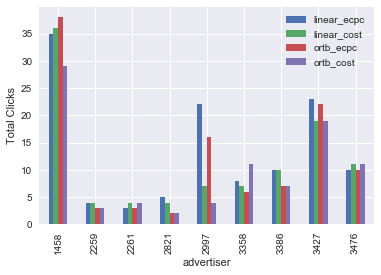

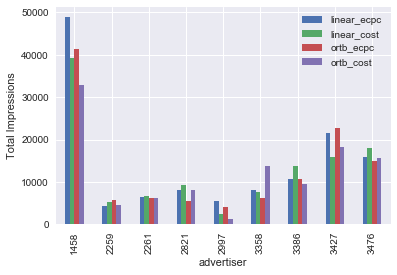

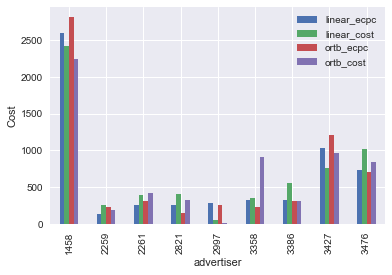

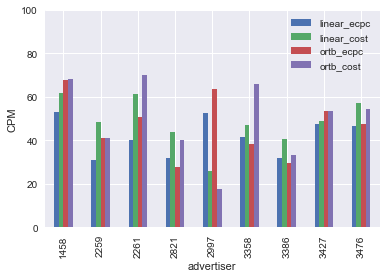

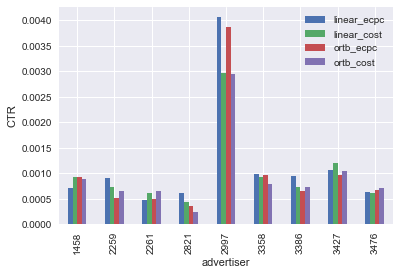

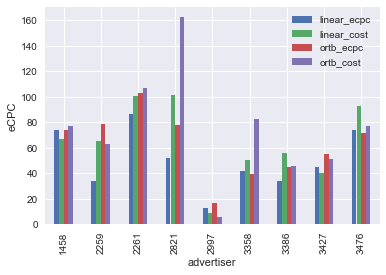

In [930]:
df_click.iloc[:9].plot.bar()
# plt.title("Budget (1/2)")
plt.ylabel('Total Clicks')

df_Imps.iloc[:9].plot.bar()
# plt.title("Budget (1/2)")
plt.ylabel('Total Impressions')

df_cost.iloc[:9].plot.bar()
# plt.title("Budget (1/2)")
plt.ylabel('Cost')

df_cpm.iloc[:9].plot.bar()
# plt.title("Budget (1/2)")
# plt.set_xlim(xmin=,)
plt.gca().set_ylim([0,100])
plt.ylabel('CPM')

df_ctr.iloc[:9].plot.bar()
# plt.title("Budget (1/2)")
plt.ylabel('CTR')

df_ecpc.iloc[:9].plot.bar()
# plt.title("Budget (1/2)")
plt.ylabel('eCPC')

In [961]:
a = df_val_linear_1_4_ecpc.ix[(df_val_linear_1_4_ecpc['advertiser']!=1458)]

In [962]:
b = df_val_ortb_1_4_ecpc.ix[(df_val_ortb_1_4_ecpc['advertiser']==1458)]

In [963]:
allab = pd.concat([a,b]).sort_index()

In [964]:
ad_go_through = -1
impression = 0.0
clicks = 0
cost = 0.0
budget = 25000 * 1000

budget = budget / 4

for click, pay_price in df_validation_original[['click','payprice']].values:
    ad_go_through += 1
    if allab['bidprice'][ad_go_through] > pay_price:
        impression += 1.0
        clicks += click
        cost += pay_price
    if cost >= budget:
        break
    if ad_go_through == 299749:
        break

In [965]:
ad_go_through

251644

In [966]:
evaluate_result(allab[:251644])

,click,Imps,cost,CPM,CTR,eCPC
advertiser,,,,,,
1458,41.0,50387.0,3421.506,67.90,0.081%,83.45
2259,3.0,3664.0,113.327,30.93,0.082%,37.78
2261,3.0,5365.0,213.847,39.86,0.056%,71.28
2821,4.0,6841.0,219.047,32.02,0.058%,54.76
2997,16.0,4549.0,237.037,52.11,0.352%,14.81
3358,6.0,6734.0,277.437,41.20,0.089%,46.24
3386,7.0,8926.0,285.711,32.01,0.078%,40.82
3427,20.0,18126.0,861.651,47.54,0.11%,43.08
3476,10.0,13374.0,620.428,46.39,0.075%,62.04


In [957]:
ad_go_through

242340

In [958]:
299749 - 242340

57409